In [22]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [23]:
def batch_normalization(X, gamma, beta, moving_mean, moving_var, epsilon, momentum):
    # 判断是否在推理模式下
    if not torch.is_grad_enabled():
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + epsilon)
    else: # 在训练模式下
        assert len(X.shape) in (2,4)
        if len(X.shape) == 2:
            # 全连接层，按列计算每个特征的均值与方差
            mean = X.mean(dim=0)
            variance = ((X - mean)**2).mean(dim=0)
        elif len(X.shape) == 4:
            # 卷积层，按通道计算每个通道的均值与方差
            mean = X.mean(dim=(0,2,3), keepdim=True)
            variance = ((X - mean)**2).mean(dim=(0,2,3),keepdim=True)
        # 移动平均计算整个训练样本的均值与方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var  = momentum * moving_var + (1.0 - momentum) * variance
        # 返回结果
        X_hat = (X - mean) / torch.sqrt(variance + epsilon)
    # 对计算结果加上伸缩系数与移位值
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

In [24]:
# def batch_normalization(X, gamma, beta, moving_mean, moving_var, epsilon, momentum):
#     # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
#     if not torch.is_grad_enabled():
#         # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
#         X_hat = (X - moving_mean) / torch.sqrt(moving_var + epsilon)
#     else:
#         assert len(X.shape) in (2, 4)
#         if len(X.shape) == 2:
#             # 使用全连接层的情况，计算特征维上的均值和方差
#             mean = X.mean(dim=0)
#             var = ((X - mean) ** 2).mean(dim=0)
#         else:
#             # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
#             # 这里我们需要保持X的形状以便后面可以做广播运算
#             mean = X.mean(dim=(0, 2, 3), keepdim=True)
#             var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
#         # 训练模式下，用当前的均值和方差做标准化
#         X_hat = (X - mean) / torch.sqrt(var + epsilon)
#         # 更新移动平均的均值和方差
#         moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
#         moving_var = momentum * moving_var + (1.0 - momentum) * var
#     Y = gamma * X_hat + beta  # 缩放和移位
#     return Y, moving_mean.data, moving_var.data

In [25]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        # num_features：完全连接层的输出数量或卷积层的输出通道数。
        # num_dims：2表示完全连接层，4表示卷积层
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        elif num_dims == 4:
            shape = (1,num_features,1,1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    def forward(self,X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y,moving_mean, moving_var = batch_normalization(X, self.gamma,self.beta,self.moving_mean,self.moving_var,epsilon=1e-5,momentum=0.9)
        return Y

In [26]:
# net = nn.Sequential(
#     nn.Conv2d(1,6,kernel_size=5), BatchNorm(6,num_dims=4),nn.Sigmoid(),
#     nn.AvgPool2d(kernel_size=2,stride=2),
#     nn.Conv2d(6,16,kernel_size=5), BatchNorm(16,num_dims=4),nn.Sigmoid(),
#     nn.AvgPool2d(kernel_size=2,stride=2),
#     nn.Flatten(),
#     nn.Linear(16*4*4,120), BatchNorm(120,num_dims=2), nn.Sigmoid(),
#     nn.Linear(120,84), BatchNorm(84,num_dims=2), nn.Sigmoid(),
#     nn.Linear(84,10)
# )

In [27]:
lr, num_epochs, batch_size = 0.6, 10, 256
train_iter , test_iter = d2l.load_data_fashion_mnist(batch_size)
# d2l.train_ch6(net, train_iter, test_iter, num_epochs,lr,d2l.try_gpu())

In [28]:
net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),nn.BatchNorm2d(6),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.BatchNorm2d(16),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*4*4,120),nn.BatchNorm1d(120), nn.ReLU(),
    nn.Linear(120,84), nn.BatchNorm1d(84), nn.ReLU(),
    nn.Linear(84, 10)
)

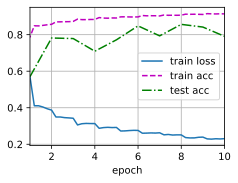

In [29]:
d2l.train_ch6(net,train_iter,test_iter,num_epochs, lr, d2l.try_gpu())